In [1]:
!python -V


Python 3.10.10


In [2]:
# !pip install pyarrow fastparquet seaborn
 

In [3]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

import mlflow


In [4]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc_taxi_experiment")

2023/04/03 12:23:11 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/04/03 12:23:11 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/home/azureuser/mlops/2- experiment-tracking/mlruns/1', creation_time=1680109439413, experiment_id='1', last_update_time=1680109439413, lifecycle_stage='active', name='nyc_taxi_experiment', tags={}>

In [5]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [6]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799829578

/tmp/ipykernel_5434/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_5434/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


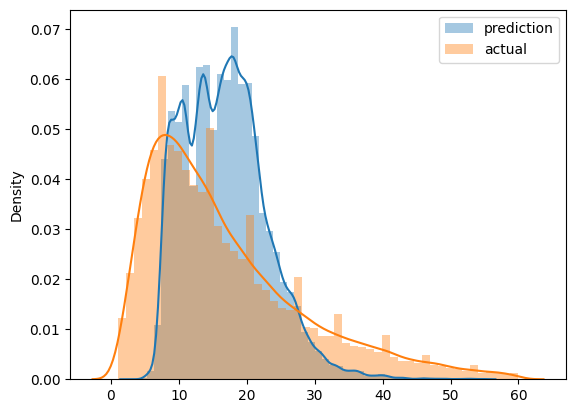

In [7]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [8]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [9]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [10]:
len(df_train), len(df_val)


(73908, 61921)

In [11]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [12]:

categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [13]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715207562129

In [15]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

### training cell:

In [16]:
# start logging with mlflow
with mlflow.start_run():
    
    # set tag for mlflow
    mlflow.set_tag("developer", "Ahmad")
    
    # set data path param
    mlflow.log_param("train-data-path", "./data/fhv_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "./data/fhv_tripdata_2021-02.parquet") 
    
    # set hyper parameter for lasso
    alpha = 0.01 
    mlflow.log_param("alpha",alpha)
    lr = Lasso(alpha=alpha)
    
    # train the model
    lr.fit(X_train, y_train)
    
    # get the predection from train data
    y_pred = lr.predict(X_val)

   # get RMSE and record on mlflow
    rmse = round(mean_squared_error(y_val, y_pred, squared=False),2)
    print("RMSE for training data:", rmse)
    mlflow.log_metric("rmse", rmse)

RMSE for training data: 11.17


### Xgboost

In [14]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [15]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [19]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[11:59:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.                                                                                                  
[0]	validation-rmse:8.58680                                                                                                                                                                                             
[1]	validation-rmse:6.95004                                                                                                                                                                                             
[2]	validation-rmse:6.73203                                                                                                                                                                                             
[3]	validation-rmse:6.68539                                                                                                         

In [18]:
params = {
    'max_depth': 4,
    'learning_rate': 0.14493221791716185,
    'reg_alpha': 0.012153110171030913,
    'reg_lambda': 0.017881159785939696,
    'min_child_weight': 0.674864917045824,
    'objective': 'reg:linear',
    'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

2023/04/03 12:52:59 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/04/03 12:52:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a217535d1cf84b5a96c870ec3cec667b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[12:52:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.63868
[1]	validation-rmse:16.49396
[2]	validation-rmse:14.70094
[3]	validation-rmse:13.20790
[4]	validation-rmse:11.97595
[5]	validation-rmse:10.96357
[6]	validation-rmse:10.13931
[7]	validation-rmse:9.46924
[8]	validation-rmse:8.92971
[9]	validation-rmse:8.49708
[10]	validation-rmse:8.15176
[11]	validation-rmse:7.87715
[12]	validation-rmse:7.65788
[13]	validation-rmse:7.48524
[14]	validation-rmse:7.34648
[15]	validation-rmse:7.23560
[16]	validation-rmse:7.14582
[17]	validation-rmse:7.07300
[18]	validation-rmse:7.01511
[19]	validation-rmse:6.96813
[20]	validation-rmse:6.93084
[21]	validation-rmse:6.89955
[22]	validation-rmse:6.87597
[23]	validation-rmse:6.85481
[24]	validation-rmse:6.83645
[25]	validation-rmse:6.82180
[26]	validation-rmse:6.80861
[27]	validation-rmse:6.79848
[28]	validation-rmse:6.79056
[29]	validation-rmse:6.78166
[30]	validatio

2023/04/03 12:53:34 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


## Load model as PyFuncModel

In [19]:
logged_model = 'runs:/a66d6ad15ca940ec92c3a475ca5928b1/model'

In [21]:
# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

[13:10:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.xgboost
  run_id: a66d6ad15ca940ec92c3a475ca5928b1

In [22]:
loaded_model.predict(X_val)

array([16.649584 ,  7.0779514, 18.543997 , ..., 13.547641 ,  6.9525642,
        8.693414 ], dtype=float32)